# LSTM

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchmetrics
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = r'C:\Users\connor\PycharmProjects\trading\data\analytics\analytics_voo.csv'
df = pd.read_csv(DATA_PATH, low_memory=False)

In [3]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'join_date', 'Id',
       'Date', 'DateLongDescription', 'DateShortDescription', 'DayLongName',
       'DayShortName', 'MonthLongName', 'MonthShortName', 'CalendarDay',
       'CalendarWeek', 'CalendarWeekStartDateId', 'CalendarWeekEndDateId',
       'CalendarDayInWeek', 'CalendarMonth', 'CalendarMonthStartDateId',
       'CalendarMonthEndDateId', 'CalendarNumberOfDaysInMonth',
       'CalendarDayInMonth', 'CalendarQuarter', 'CalendarQuarterStartDateId',
       'CalendarQuarterEndDateId', 'CalendarQuarterStartDate',
       'CalendarNumberOfDaysInQuarter', 'CalendarDayInQuarter', 'CalendarYear',
       'CalendarYearEndDateId', 'CalendarYearStartDate',
       'CalendarNumberOfDaysInYear', 'month_join_key', 'year_join_key',
       'seven_day_ema', 'CPALTT01USM657N', 'DFF', 'EXPINF10YR', 'GDPC1',
       'RSXFS', 'T10YFF', 'UNRATE', 'macd', 'macd_signal', 'macd_hist',
       'daily_obv', 'target'],
      dtype='object')

In [4]:
non_target_columns = ['open', 'high', 'low', 'close', 'volume', 'CPALTT01USM657N', 'DFF', 'EXPINF10YR', 'GDPC1', 'RSXFS', 'T10YFF', 'UNRATE', 'macd', 'macd_signal', 'macd_hist', 'daily_obv', 'seven_day_ema', 'close', 'target']

df_cols = df[non_target_columns]

# version with just close price and date
df_target_train = df[['date', 'target']].where(df.date <= '2020-01-01')
df_target_train.dropna(inplace=True)
df_target_test = df[['date', 'target']].where(df.date > '2020-01-01')
df_target_test.dropna(inplace=True)

# version with all columns
df_target_train_v2 = df[non_target_columns].where(df.date <= '2020-01-01')
df_target_train_v2.dropna(inplace=True)
df_target_test_v2 = df[non_target_columns].where(df.date > '2020-01-01')
df_target_test_v2.dropna(inplace=True)

In [5]:
print(df_target_train.columns)
print()
print(df_target_train_v2.columns)

Index(['date', 'target'], dtype='object')

Index(['open', 'high', 'low', 'close', 'volume', 'CPALTT01USM657N', 'DFF',
       'EXPINF10YR', 'GDPC1', 'RSXFS', 'T10YFF', 'UNRATE', 'macd',
       'macd_signal', 'macd_hist', 'daily_obv', 'seven_day_ema', 'close',
       'target'],
      dtype='object')


In [6]:
seed = 0

In [7]:
def create_sequences(df, seq_length, num_rows=len(df), include_all_features=False):
    """
    Input:
    df: pandas dataframe with at least 2 columns, a date column and a target column
    seq_length: How long the sequence should be. 
    num_rows: How many rows to use. Will pull all rows unless num_rows is provided, in which case the top num_rows will be pulled.
    include_all_features: Whether to use just the target column for the sequence, or to include all features.
        
    Output:
    Generates a sequence of seq_length length. It's shape is [num_rows, seq_length] if include_all_features is False, else [num_rows, seq_length * len(df.columns)]. 
    A sequence refers to how many should be appended as columns. 
    For example, if df = [['2020-01-01',100], ['2020-01-02', 101], ['2020-01-03', 102]] and seq_length = 2, the generated sequence will be [[101,102], [102,103]]. 
    """
    
    
    xs, ys = [], []
    
    if include_all_features == False:
        for itr in range(num_rows - seq_length):
            x = df.iloc[itr:(itr + seq_length), -1]
            y = df.iloc[itr + seq_length, -1]
            xs.append(x)
            ys.append(y)
    elif include_all_features == True:
        for itr in range(num_rows - seq_length):
            x = df.iloc[itr:(itr + seq_length), :]
            y = df.iloc[itr + seq_length, -1]
            xs.append(x)
            ys.append(y)

    else:
        print(f"error: include_all_features accepts True or False, got {include_all_features} instead.")
    return np.array(xs), np.array(ys)

In [8]:
# create training set
sequence_len = 10
num_rows = 200000
X_train, y_train = create_sequences(df_target_train, sequence_len, num_rows)
X_test, y_test = create_sequences(df_target_test, sequence_len, num_rows)

X_train_v2, y_train_v2 = create_sequences(df_target_train_v2, sequence_len, num_rows, include_all_features=True)
X_test_v2, y_test_v2 = create_sequences(df_target_test_v2, sequence_len, num_rows, include_all_features=True)

In [9]:
df[non_target_columns].head(n=100)

,open,high,low,close,volume,CPALTT01USM657N,DFF,EXPINF10YR,GDPC1,RSXFS,T10YFF,UNRATE,macd,macd_signal,macd_hist,daily_obv,seven_day_ema,close,target
0,83.935,84.042,83.820,83.967,232,0.12452,0.19,1.574237,16960.864,323990.0,2.48,9.4,1.1427,1.1947,-0.0521,-148100.0,81.6086,83.967,0
1,83.888,83.995,83.743,83.889,150,0.12452,0.19,1.574237,16960.864,323990.0,2.48,9.4,1.1427,1.1947,-0.0521,-148100.0,81.6086,83.889,1
2,83.888,83.995,83.774,83.920,1600,0.12452,0.19,1.574237,16960.864,323990.0,2.48,9.4,1.1427,1.1947,-0.0521,-148100.0,81.6086,83.920,1
3,83.904,84.011,83.776,83.923,100,0.12452,0.19,1.574237,16960.864,323990.0,2.48,9.4,1.1427,1.1947,-0.0521,-148100.0,81.6086,83.923,1
4,83.966,84.073,83.851,83.998,698,0.12452,0.19,1.574237,16960.864,323990.0,2.48,9.4,1.1427,1.1947,-0.0521,-148100.0,81.6086,83.998,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,83.577,83.684,83.463,83.609,50,0.12452,0.19,1.574237,16960.864,323990.0,2.56,9.4,1.1110,1.1834,-0.0724,-165200.0,81.7122,83.609,1
96,83.608,83.715,83.494,83.640,93,0.12452,0.19,1.574237,16960.864,323990.0,2.56,9.4,1.1110,1.1834,-0.0724,-165200.0,81.7122,83.640,0
97,83.593,83.700,83.479,83.625,100,0.12452,0.19,1.574237,16960.864,323990.0,2.56,9.4,1.1110,1.1834,-0.0724,-165200.0,81.7122,83.625,1
98,83.733,83.840,83.618,83.765,100,0.12452,0.19,1.574237,16960.864,323990.0,2.56,9.4,1.1110,1.1834,-0.0724,-165200.0,81.7122,83.765,1


In [10]:
X_train[0]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0.])

In [11]:
y_train[0]

1.0

In [12]:
X_train_v2[0]

array([[ 8.39350000e+01,  8.40420000e+01,  8.38200000e+01,
         8.39670000e+01,  2.32000000e+02,  1.24519889e-01,
         1.90000000e-01,  1.57423670e+00,  1.69608640e+04,
         3.23990000e+05,  2.48000000e+00,  9.40000000e+00,
         1.14270000e+00,  1.19470000e+00, -5.21000000e-02,
        -1.48100000e+05,  8.16086000e+01,  8.39670000e+01,
         0.00000000e+00],
       [ 8.38880000e+01,  8.39950000e+01,  8.37430000e+01,
         8.38890000e+01,  1.50000000e+02,  1.24519889e-01,
         1.90000000e-01,  1.57423670e+00,  1.69608640e+04,
         3.23990000e+05,  2.48000000e+00,  9.40000000e+00,
         1.14270000e+00,  1.19470000e+00, -5.21000000e-02,
        -1.48100000e+05,  8.16086000e+01,  8.38890000e+01,
         1.00000000e+00],
       [ 8.38880000e+01,  8.39950000e+01,  8.37740000e+01,
         8.39200000e+01,  1.60000000e+03,  1.24519889e-01,
         1.90000000e-01,  1.57423670e+00,  1.69608640e+04,
         3.23990000e+05,  2.48000000e+00,  9.40000000e+00,
    

In [13]:
y_train_v2[0]

1.0

In [14]:
print(len(X_train), len(X_train_v2))
print(len(y_train), len(y_train_v2))

199990 199990
199990 199990


# using all fields available

In [15]:
# convert df into objects Torch can read
torch_X_train  = torch.from_numpy(X_train_v2).float()
torch_y_train = torch.from_numpy(y_train_v2).float()
torch_X_test = torch.from_numpy(X_test_v2).float()
torch_y_test = torch.from_numpy(y_test_v2).float()

# normalize data
torch_X_train = torch.nn.functional.normalize(torch_X_train)
torch_X_test = torch.nn.functional.normalize(torch_X_test)

print(torch_X_train.shape, torch_y_train.shape)
# create test and train sets
train_data_set = TensorDataset(torch_X_train, torch_y_train)
test_data_set = TensorDataset(torch_X_test, torch_y_test)

# confirm it works
sample = train_data_set[0]
input_sample, label_sample = sample
print('input sample:', input_sample)
print('label sample:', label_sample)

torch.Size([199990, 10, 19]) torch.Size([199990])
input sample: tensor([[ 0.3158,  0.3158,  0.3158,  0.3158,  0.1254,  0.3162,  0.3162,  0.3162,
          0.3162,  0.3162,  0.3162,  0.3162,  0.3162,  0.3162, -0.3162, -0.3162,
          0.3162,  0.3158,  0.0000],
        [ 0.3156,  0.3156,  0.3155,  0.3155,  0.0811,  0.3162,  0.3162,  0.3162,
          0.3162,  0.3162,  0.3162,  0.3162,  0.3162,  0.3162, -0.3162, -0.3162,
          0.3162,  0.3155,  0.3780],
        [ 0.3156,  0.3156,  0.3156,  0.3156,  0.8650,  0.3162,  0.3162,  0.3162,
          0.3162,  0.3162,  0.3162,  0.3162,  0.3162,  0.3162, -0.3162, -0.3162,
          0.3162,  0.3156,  0.3780],
        [ 0.3157,  0.3157,  0.3156,  0.3156,  0.0541,  0.3162,  0.3162,  0.3162,
          0.3162,  0.3162,  0.3162,  0.3162,  0.3162,  0.3162, -0.3162, -0.3162,
          0.3162,  0.3156,  0.3780],
        [ 0.3159,  0.3159,  0.3159,  0.3159,  0.3774,  0.3162,  0.3162,  0.3162,
          0.3162,  0.3162,  0.3162,  0.3162,  0.3162,  0.31

# Using just the close price

In [16]:
# # convert df into objects Torch can read
# torch_X_train  = torch.from_numpy(X_train).float()
# torch_y_train = torch.from_numpy(y_train).float()
# torch_X_test = torch.from_numpy(X_test).float()
# torch_y_test = torch.from_numpy(y_test).float()
# 
# # create test and train sets
# train_data_set = TensorDataset(torch_X_train, torch_y_train)
# test_data_set = TensorDataset(torch_X_test, torch_y_test)
# 
# # confirm it works
# sample = train_data_set[0]
# input_sample, label_sample = sample
# print('input sample:', input_sample)
# print('label sample:', label_sample)

In [17]:
print(input_sample.shape)

torch.Size([10, 19])


In [18]:
num_features = len(df_target_train_v2.columns)
batch_size = 1000
shuffle = False
hidden_size = round(num_features / 2)
num_layers = 2
dropout = .25

learning_rate = 0.0001
num_epochs = 50

# create dataloader
train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=shuffle, drop_last=True)
test_dataloader = DataLoader(test_data_set, batch_size=batch_size, shuffle=shuffle, drop_last=True)
# test loader
# x, y = next(iter(train_dataloader))
# 
# print('x', x, 'y', y)

In [19]:
# LTSM
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__() #super makes all the methods available in nn.Module available for the new class Net
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(in_features=hidden_size, out_features=1)
        self.sigmoid = nn.Sigmoid() # we want a binary output, not %

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [20]:
net = Net(input_size=num_features)
criterion = nn.BCELoss(reduction='sum') # for binary prediction. Using the 'target' column
#criterion = nn.MSELoss() # for regression, predicting the 'close' column
optimizer = optim.Adam(
    net.parameters(), lr=learning_rate
)
acc = torchmetrics.Accuracy(task="binary")

for epoch in range(num_epochs):
    for dummy, data in enumerate(train_dataloader): # enumerate ensures that the dataloader always starts at the beginning since it's a generator object
        torch.manual_seed(seed)
        seqs = data[0].view(batch_size, sequence_len, num_features)
        outputs = net(seqs).squeeze()
        loss = criterion(outputs, data[1])
        acc(torch.round(outputs), data[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {acc.compute()}")
    # early break if loss isn't changing beyond the learning rate
    if loss.item() < .1:
        break

Epoch 1, Loss: 683.84423828125, Accuracy: 0.5692110657691956
Epoch 2, Loss: 683.2634887695312, Accuracy: 0.5692110657691956
Epoch 3, Loss: 683.1367797851562, Accuracy: 0.5692110657691956
Epoch 4, Loss: 683.0953369140625, Accuracy: 0.5692110657691956
Epoch 5, Loss: 683.0692749023438, Accuracy: 0.5692110657691956
Epoch 6, Loss: 683.047119140625, Accuracy: 0.5692110657691956
Epoch 7, Loss: 683.0264892578125, Accuracy: 0.5692110657691956
Epoch 8, Loss: 683.0069580078125, Accuracy: 0.5692110657691956
Epoch 9, Loss: 682.988037109375, Accuracy: 0.5692110657691956
Epoch 10, Loss: 682.9697265625, Accuracy: 0.5692110657691956
Epoch 11, Loss: 682.9518432617188, Accuracy: 0.5692110657691956
Epoch 12, Loss: 682.9346923828125, Accuracy: 0.5692110657691956
Epoch 13, Loss: 682.9179077148438, Accuracy: 0.5692110657691956
Epoch 14, Loss: 682.9017333984375, Accuracy: 0.5692110657691956
Epoch 15, Loss: 682.8863525390625, Accuracy: 0.5692110657691956
Epoch 16, Loss: 682.87158203125, Accuracy: 0.56921106576

In [21]:
# param_grid = {
#     'hidden_size': [5, 10, num_features]
#     , 'num_layers': range(4)
#     , 'dropout': [.1, .5, .9]
#     , 'learning_rate': [.0001, .0005, .001]
#     , 'num_epochs': [10, 25, 50]}
#
# best_params = {'hidden_size': 0, 'num_layers': 0, 'dropout': 0, 'learning_rate': 0, 'num_epochs': 0}

In [22]:
# # Define MSE metric
# mse = torchmetrics.regression.MeanSquaredError()
# 
# net.eval()
# with torch.no_grad():
#     for seqs, labels in test_dataloader:
#         seqs = seqs.view(batch_size, torch_X_test.shape[1], num_features)
#         # Pass seqs to net and squeeze the result
#         outputs = net(seqs).squeeze()
#         mse(outputs, labels)
# 
# # Compute final metric value
# test_mse = mse.compute()
# print(f"Test MSE: {test_mse}")
# print(f"Test RMSE: {test_mse**.5}")

In [23]:
# test score

net.eval()
with torch.no_grad():
    for dummy, data in enumerate(test_dataloader):
        torch.manual_seed(seed)
        seqs = data[0].view(batch_size, sequence_len, num_features)
        outputs = net(seqs).squeeze()
        acc(torch.round(outputs), data[1])

print(f"Test accuracy score: {acc.compute()}")

Test accuracy score: 0.5680500268936157


# Results

Baseline guessing 

In [24]:
random_guess_likelihood = df.target.mean()
# mean = percent the candle was higher than the previous candle

print('Random guess likelihood', random_guess_likelihood)

Random guess likelihood 0.4687579112426077


# Writeup
At the minute level, 46.875% of the time the next close price is higher than the previous close price for VOO.
The model is able to correctly predict a candle 56.3131% of the time making it better than a random (weighted) coinflip. The thing holding the model back is that it doesn't take into account expected payoff. The average positive candel is higher than the average negative candle in absolute terms. The model is doing almost exactly as well on the train and test set so there is not any overfitting going on. The accuracy is a bit low though so even though it's a nn it has high bias and underfitting overall.


I used the following hyperparameters:
sequence_len = 10
* Sequence of length 10 seemed to give sufficient information without overwhelming my computer. Each input becomes sequence_len * feature so the compute cost is quite high increasing this value
num_rows = 100000
* This is to limit how much data I'm using. Adding more data doesn't seem to improve accuracy but it does crash performance.
batch_size = 1000
* Mostly arbitarily chosen. 1000 makes the model run faster and doesn't seem to sacrifice accuracy either.
shuffle = False
* don't want to shuffle sequence data since that defeats the purpose
hidden_size = round(num_features / 2)
* Heuristic that the best hidden_size is based on the average between the input and output sizes. Here my output is just 1 so it's just the number of features divided by 2
num_layers = 2
* Again heuristic, 2 hidden layers should be able to solve anything
dropout = .5
* Another mostly random chosen value. Playing around with this doesn't impact the model too much.

learning_rate = 0.0001
* small enough to change directions but not too small to where it doesn't update
num_epochs = 50
* Probably don't need this many. It stops really changing much after like 3-4 epochs


I chose not to do dimensionality reduction for the LSTM model. I'm allowing the model to figure out which features and relationships are important or not. A big part of the value of deep learning is that it doesn't require me doing any sort of feature engineering or reduction.


# LSTM Tuning


In [25]:
def train_and_evaluate(model, num_epochs, batch_size):
    criterion = nn.BCELoss(reduction='sum') # for binary prediction. Using the 'target' column
    #criterion = nn.MSELoss() # for regression, predicting the 'close' column
    optimizer = optim.Adam(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        for dummy, data in enumerate(train_dataloader):
            model.train() # Since you called model.eval() above this is still the last mode it was set in. So you need to move it back to train
            torch.manual_seed(seed)
            seqs = data[0].view(batch_size, sequence_len, num_features)
            outputs = model(seqs).squeeze()
            loss = criterion(outputs, data[1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    # don't update the weights after each batch        
    model.eval()
    with torch.no_grad():
        for dummy, data in enumerate(test_dataloader):
            torch.manual_seed(seed)
            seqs = data[0].view(batch_size, sequence_len, num_features)
            outputs = model(seqs).squeeze()
            acc(torch.round(outputs), data[1])
    
    return acc.compute().numpy()

In [26]:
learning_rates = [.00001, .00005, .0001]
batch_sizes = [1000, 5000]
epochs = [2, 3, 5, 10, 50]

In [27]:
best_score = 0
best_params = None
for lr in learning_rates:
    for bs in batch_sizes:
        for ne in epochs:
            # Create DataLoaders with current batch_size
            train_dataloader = DataLoader(train_data_set, batch_size=bs, shuffle=shuffle, drop_last=True)
            test_dataloader = DataLoader(test_data_set, batch_size=bs, shuffle=shuffle, drop_last=True)
            
            model = Net(input_size=num_features)
            current_score = train_and_evaluate(model, ne, bs)

            # Update best_score and best_params if current_score is better
            print('learning_rate:', lr, 'batch_size:', bs, 'ne:', ne, 'current_score:', current_score)
            if current_score > best_score:
                best_score = current_score
                best_params = {'learning_rate': lr, 'batch_size': bs, 'num_epochs': ne}

print("Best hyperparameters:", best_params)
print("Best score:", best_score) 

learning_rate: 1e-05 batch_size: 1000 ne: 2 current_score: 0.5669337
learning_rate: 1e-05 batch_size: 1000 ne: 3 current_score: 0.5658595
learning_rate: 1e-05 batch_size: 1000 ne: 5 current_score: 0.56482506
learning_rate: 1e-05 batch_size: 1000 ne: 10 current_score: 0.56382823
learning_rate: 1e-05 batch_size: 1000 ne: 50 current_score: 0.562867
learning_rate: 1e-05 batch_size: 5000 ne: 2 current_score: 0.56195456
learning_rate: 1e-05 batch_size: 5000 ne: 3 current_score: 0.561073
learning_rate: 1e-05 batch_size: 5000 ne: 5 current_score: 0.5602207
learning_rate: 1e-05 batch_size: 5000 ne: 10 current_score: 0.5593963
learning_rate: 1e-05 batch_size: 5000 ne: 50 current_score: 0.55859846
learning_rate: 5e-05 batch_size: 1000 ne: 2 current_score: 0.55781335
learning_rate: 5e-05 batch_size: 1000 ne: 3 current_score: 0.5570532
learning_rate: 5e-05 batch_size: 1000 ne: 5 current_score: 0.55631685
learning_rate: 5e-05 batch_size: 1000 ne: 10 current_score: 0.55560315
learning_rate: 5e-05 bat

In [28]:
def plot_best_model(model, best_params, train_data_set, test_data_set):
    
    train_dataloader = DataLoader(train_data_set, batch_size=best_params['batch_size'], shuffle=False, drop_last=True)
    test_dataloader = DataLoader(test_data_set, batch_size=best_params['batch_size'], shuffle=False, drop_last=True)
    
    criterion = nn.BCELoss(reduction='sum') # for binary prediction. Using the 'target' column
    #criterion = nn.MSELoss() # for regression, predicting the 'close' column
    optimizer = optim.Adam(
        net.parameters(), lr=best_params['learning_rate']
    )
    
    predictions = []
    
    for epoch in range(best_params['num_epochs']):
        for dummy, data in enumerate(train_dataloader):
            torch.manual_seed(seed)
            model.train()
            seqs = data[0].view(best_params['batch_size'], sequence_len, num_features)
            outputs = model(seqs).squeeze()
            loss = criterion(outputs, data[1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    model.eval()
    with torch.no_grad():
        for dummy, data in enumerate(test_dataloader):
            torch.manual_seed(seed)
            seqs = data[0].view(best_params['batch_size'], sequence_len, num_features)
            outputs = model(seqs).squeeze()
            predictions.append(outputs)
            
    predictions = np.array(predictions).reshape(-1,1)
    plt.plot(predictions)
    plt.title("Stock Predictions")
    plt.xlabel("1-minute candles from 2020-01-01")
    plt.ylabel("Probability next close price is higher than the current close price")
    plt.show() 

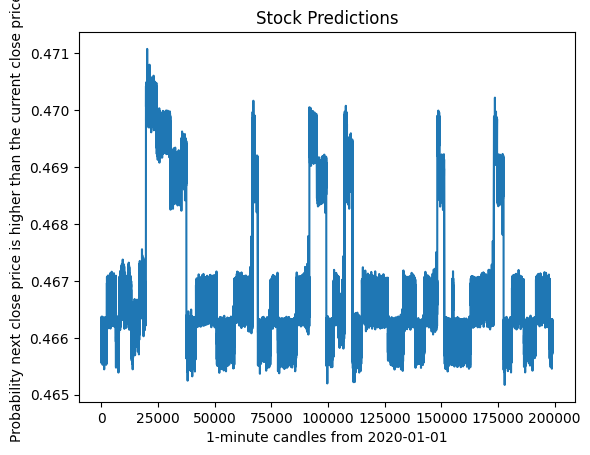

In [29]:
net = Net(input_size=num_features)

plot_best_model(net, best_params, train_data_set, test_data_set)

<Axes: title={'center': 'VOO Stock Price'}, xlabel='1-minute candle starting from 2020-01-01', ylabel='Actual Stock Price'>

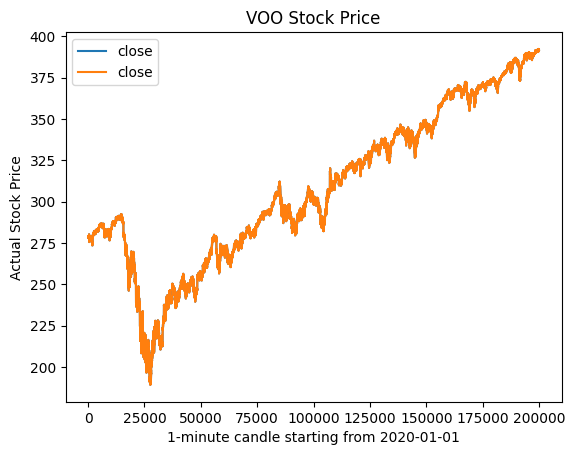

In [30]:
df_target_test_v2.reset_index(inplace=True)
df_target_test_v2['close'].iloc[:num_rows].plot(title="VOO Stock Price", ylabel="Actual Stock Price", xlabel="1-minute candle starting from 2020-01-01")

# Final Report

Parameter tuning does very little to improve the model. The only thing that seems to make a difference is using a smaller number of epochs. To make this project shine a bit more, future work should include additional data gathering, especially data that isn't already strongly correlated with the existing features. There is also room to change this from a binary classification task to a regression task. What is currently lost is that not all positive or negative candles have the same magnitutde. Simply predicting up or down might have worse value than either a regression task or a multi classifier that could improve the rate of return on investments. Additionally, having a more zoomed out look might actually be more valuable. Instead of predicting each minute candle, predicting each hour or day may yield better results. I should also include training data much closer to the current year. I split based on pre 2020 and post 2020 which makes modern predictions less useful. 

The parameters I changed were: Best hyperparameters: {'learning_rate': 1e-05, 'batch_size': 1000, 'num_epochs': 2}


It looks like the model doesn't do a better job than the baseline choosing to never buy. Since 52-53% of the time the close price is lower than the previous close price, the model seems to have picked that up and has almost the exact same prediction rate. Due to the nature of the problem, it seems that predictions seem to get stuck right below .5, which translates to always not buying. This does actually make sense. If the data is unable to yield any actionable patterns that would be better than the expected value of the stock price, then it's better just to pick the expected stock value which is just always 0 when rounded. While I'm not about to break any new ground in stock trading strategies, it does support a widely held belief that holding an SP500 ETF has a better payoff that just about any strategy. If this were converted from binary to regression I'd wager it would suggest always buying and not selling since that would have the highest total expected payout.       